In this Kaggle we are trying to predict if a loan will default or not based on certain features like age, income, loan income and credit history. In this exercice we are not interested in knowing when the loan will default. Indeed a loan can default anytime during its life. Here we are only trying to predict if the loan will default at some point during the loan term. The loan dataset covers all types of loans such as education loans, personal loans, medical loans or home improvement loans. However the dataset does not include real estate loans aka mortgages. We will assume that the feature values from the dataset are given at the moment of the loan application. For instance if person_age = 30 in the data, this means the applicant was 30 years old at the time of the loan application. The training loan dataset contains about 58k rows. As ruled by Kaggle, we will use the AUC area under the ROC curve in order to assess the performance of our model. 

Train.csv: Contains the training data with features and the binary target variable (loan_status). <br>
Test.csv: Contains the test data where participants need to predict the probabilities of loan approval. <br>
Sample_submission.csv: A sample submission file illustrating the correct format for submissions. 

PART 1 : IMPORT PACKAGES AND DATA

In [1]:
#Import packages
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from lightgbm import LGBMClassifier

In [2]:
#Check python version and env
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:14:12) [Clang 14.0.6 ]


In [3]:
#Pull data from file
df_train = pd.read_csv('loan_approval_pred_train.csv')
df_submission = pd.read_csv('loan_approval_pred_test.csv')

PART 2 : UNDERSTAND AND EXPLORE DATASOURCE

In [4]:
#Pull features from training dataset
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

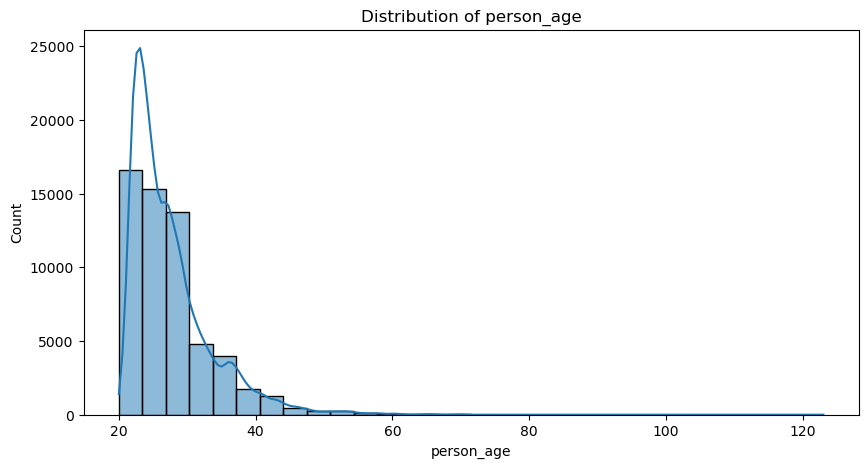

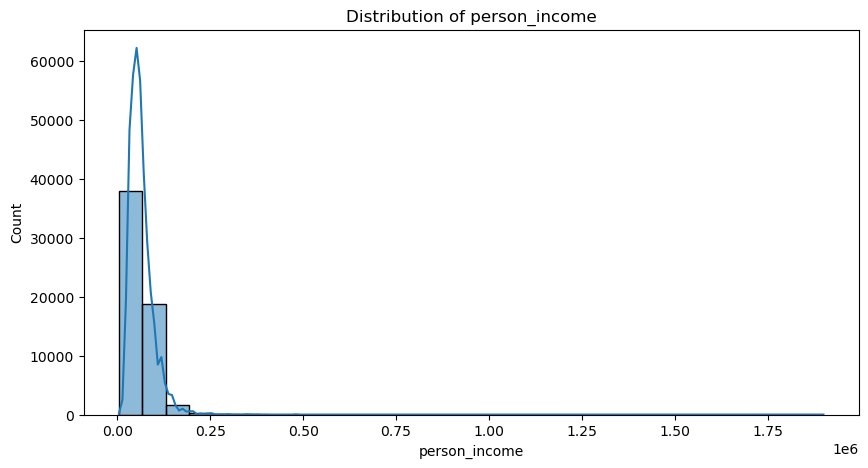

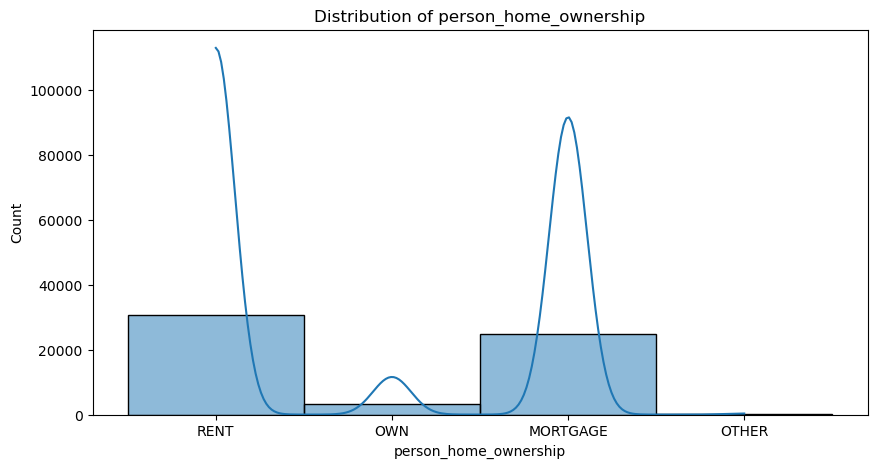

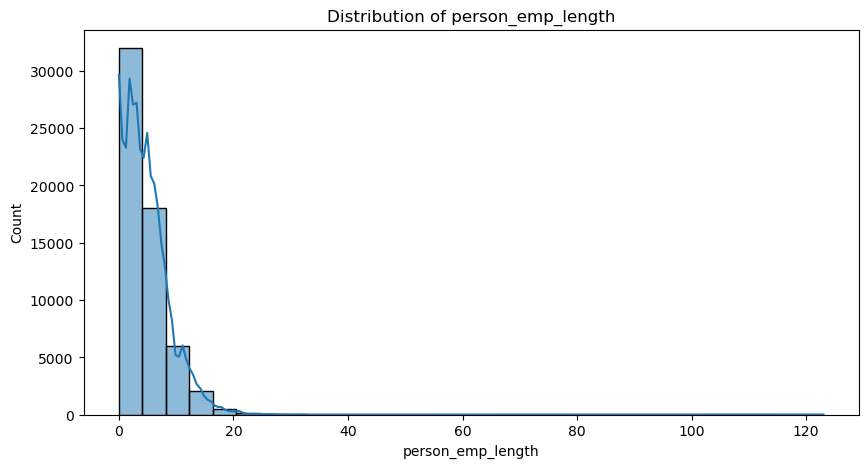

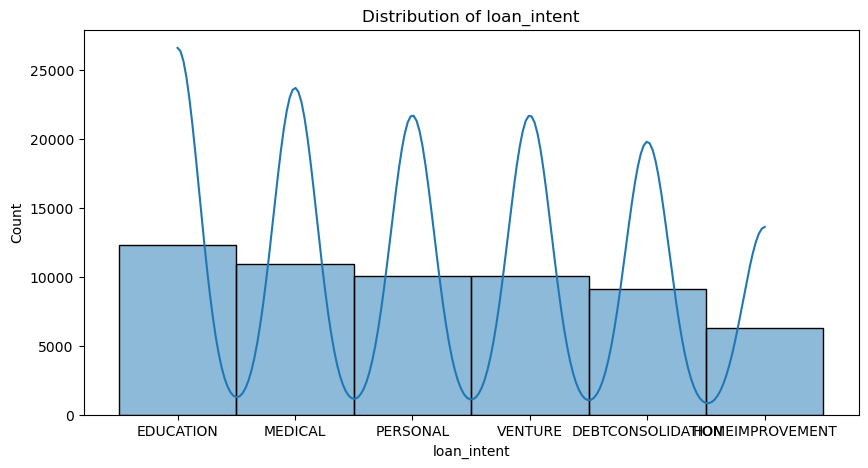

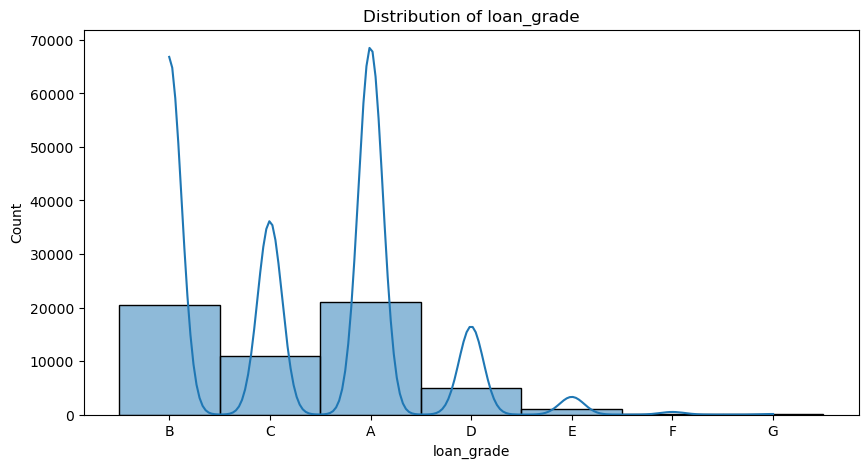

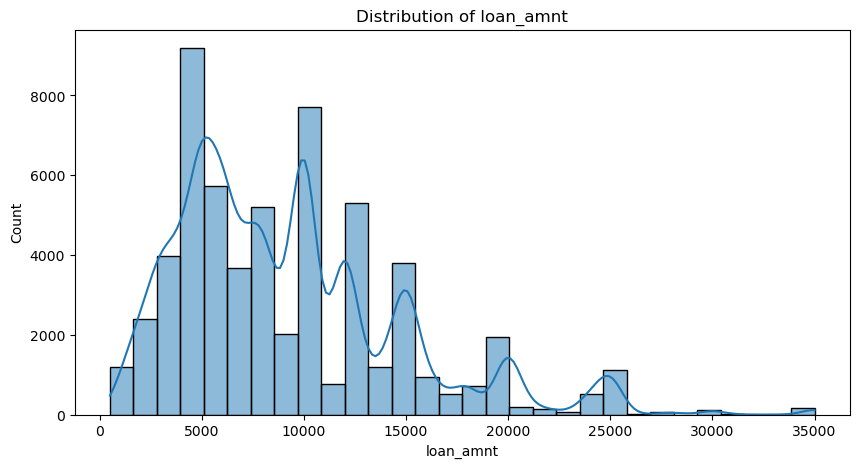

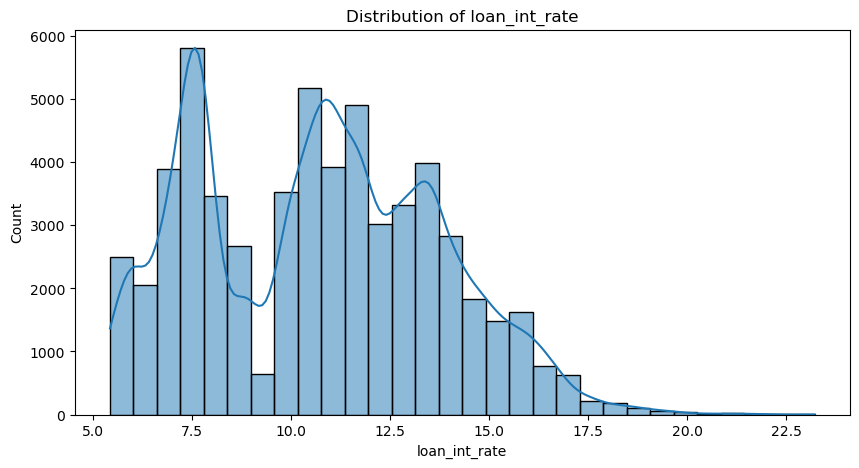

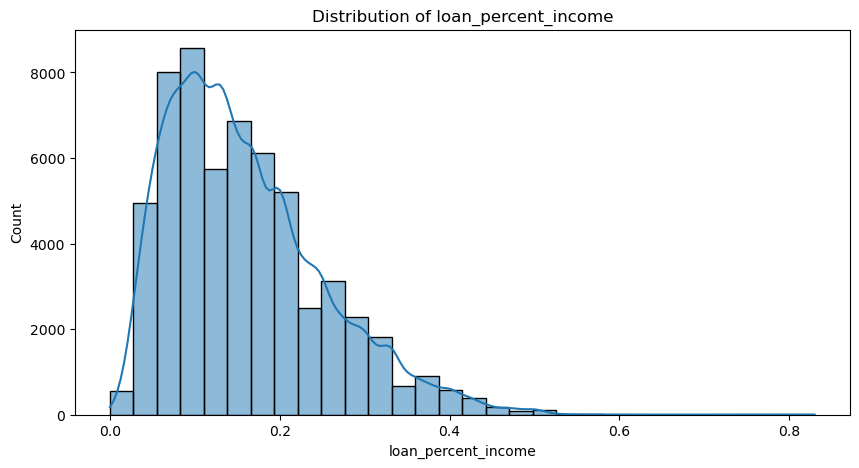

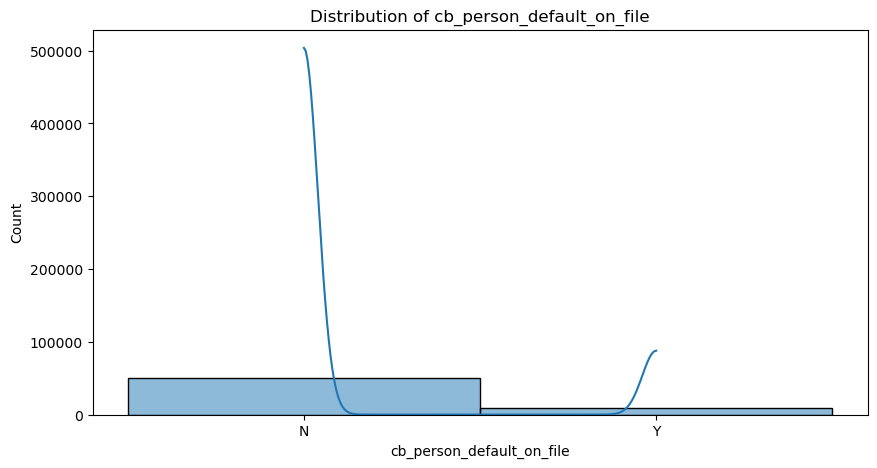

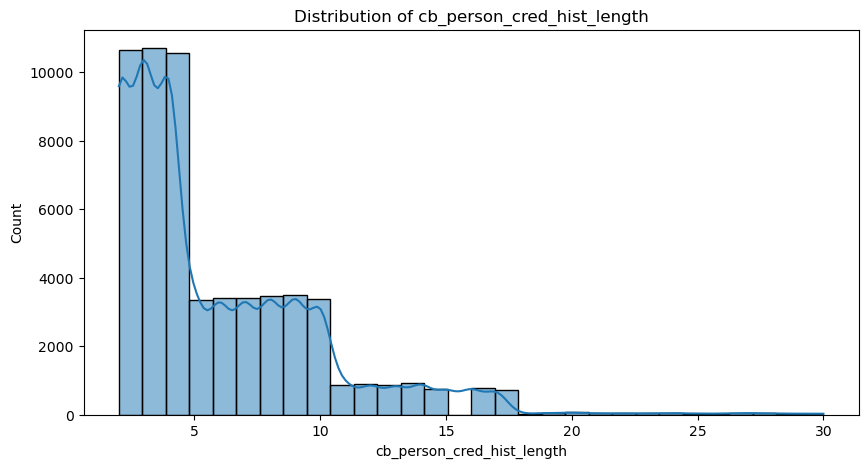

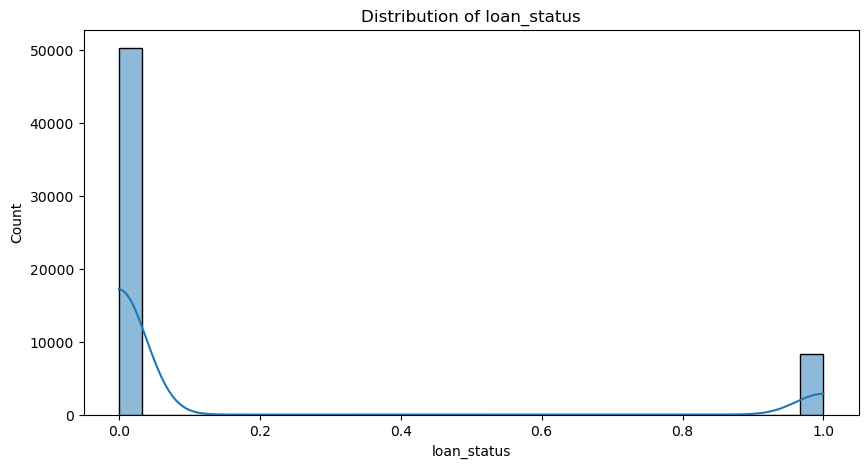

In [5]:
#Represent the distribution of each feature using histograms
for col in df_train.columns:
    if col not in ['id']:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_train['{}'.format(col)], bins=30, kde=True)
        plt.title('Distribution of {}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.show()

                                  id  person_age  person_income  \
id                          1.000000    0.008608      -0.001896   
person_age                  0.008608    1.000000       0.102176   
person_income              -0.001896    0.102176       1.000000   
person_emp_length           0.005376    0.121276       0.164042   
loan_amnt                  -0.000403    0.050378       0.310942   
loan_int_rate              -0.003454    0.009653      -0.057611   
loan_percent_income        -0.002677   -0.031975      -0.280314   
cb_person_cred_hist_length  0.008139    0.874260       0.082727   
loan_status                -0.008138   -0.001130      -0.169956   

                            person_emp_length  loan_amnt  loan_int_rate  \
id                                   0.005376  -0.000403      -0.003454   
person_age                           0.121276   0.050378       0.009653   
person_income                        0.164042   0.310942      -0.057611   
person_emp_length            

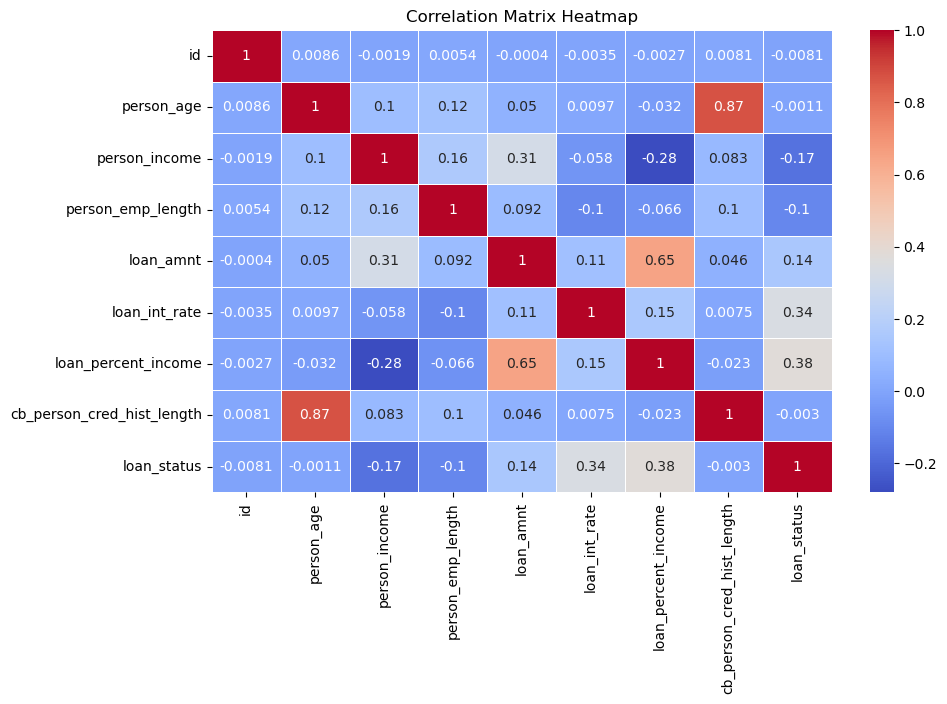

In [6]:
#Represent correlation matrix for numerical features

#Step 0: Split features into two groups numerical and categorical
categorical_features = df_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features =df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 1: Calculate the correlation matrix
correlation_matrix = df_train[numerical_features].corr()

# Step 2: Display the correlation matrix
print(correlation_matrix)

# Step 3: Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Only two sets of features have high correlation : person_age and cb_person_cred_hist_length plus loan_amt and loan_percent_income

In [7]:
#Pull statistics of each feature
for col in df_train.columns:
    print('')
    print(df_train[col].describe())


count    58645.000000
mean     29322.000000
std      16929.497605
min          0.000000
25%      14661.000000
50%      29322.000000
75%      43983.000000
max      58644.000000
Name: id, dtype: float64

count    58645.000000
mean        27.550857
std          6.033216
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        123.000000
Name: person_age, dtype: float64

count    5.864500e+04
mean     6.404617e+04
std      3.793111e+04
min      4.200000e+03
25%      4.200000e+04
50%      5.800000e+04
75%      7.560000e+04
max      1.900000e+06
Name: person_income, dtype: float64

count     58645
unique        4
top        RENT
freq      30594
Name: person_home_ownership, dtype: object

count    58645.000000
mean         4.701015
std          3.959784
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

count         58645
unique            6
top      

PART 3 : DATA CLEANING

In [8]:
#Remove outliers values 
for col in numerical_features:
    
    # Step 1: Load the dataset
    df_train = df_train
    
    # Step 2: Calculate Q1 (25th percentile) and Q3 (75th percentile) for person_income
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    
    # Step 3: Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Step 4: Define the lower and upper bound for outliers
    lower_bound = Q1 - 3 * IQR #usual threshold is 1.5 but it was returning too many outliers)
    upper_bound = Q3 + 3 * IQR #usual threshold is 1.5 but it was returning too many outliers)
    
    # Step 5: Pull the outliers (person_income values below or above the bounds)
    outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
    
    # Step 6: Display the outliers
    percentage_outliers = (len(outliers) / len(df_train)) * 100
    print('{} : {}'.format(col,percentage_outliers))

id : 0.0
person_age : 0.7383408645238297
person_income : 0.9105635604058316
person_emp_length : 0.12106743967942706
loan_amnt : 0.2643021570466365
loan_int_rate : 0.0
loan_percent_income : 0.005115525620257482
cb_person_cred_hist_length : 0.42458862648137097
loan_status : 14.238212976383323


In [9]:
#Remove null values
null_percentage = df_train.isnull().mean() * 100
print(null_percentage)

id                            0.0
person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


The percentage of outliers is very low. The percentage of null values is zero. Data is in good shape overall so there is no need to clean it. Note that this is not a very common situation. In real life datasets, the data is usually not in good shape. There are often outliers to remove and null values to either delete or fill. 

PART 4 : METRIC AND MODEL SELECTION

The problem is unbalanced. Only 16% of the rows have loan status equal to 1. As a result accuracy is not the best metric to use in order to assess the performance of the model. We should use precision, recall or both if they are equally important. Let's figure out which one is more important. 

If the lender lends Y USD to person A because the model says it is safe to lend to this person, and person A defaults at time D with X USD paid toward principal, then the lender would lose Y - X - interests paid from t = 0 to t = D. If the lender does not lend Y USD to person B because the model wrongly assumes that person B will eventually default on the loan, then the lender would have lost all interests paid from t = 0 to t = N with N being the duration of the loan. 

Lending money to a person which will not pay back is more costly than missing a person which would have paid back everything. As a result the model needs to have a better recall than precision. In real life we would use recall and F1 score as primary evaluation metrics for our model. Accuracy and precsion will be secondary metrics for performance evaluation. In this Kaggle we will evaluate the model using the area under the ROC curve (AUC) based on the predicted probabilities and the actual loan status.

Since the problem is slightly unbalanced and the relationship between the features and the target is complex, we will use a LGBM model.
The LGBM model refers to a machine learning model built using LightGBM (Light Gradient Boosting Machine), which is a powerful and efficient implementation of the gradient boosting framework. It is specifically designed to handle large datasets and offers faster training speed and better performance than traditional gradient boosting methods. It does not require data pre-processing and handles very well outliers and missing values. 

PART 5 : FEATURE ENGINEERING : FEATURE SELECTION + FEATURE PREPROCESSING

In the following sections we will start by training the model with all features and default hyperparameters. We will optimize hyperparameters later. Also, there is no features preprocessing work to do since we use a LGBM model.

In [10]:
print(categorical_features)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [11]:
FEATURES = [
'person_age',
'person_income',
'person_home_ownership',
'person_emp_length',
'loan_intent',
'loan_grade', 
'loan_amnt',
'loan_int_rate',
'loan_percent_income', 
'cb_person_default_on_file',
'cb_person_cred_hist_length', 
'loan_status'
]

FEATURES_TRAIN = [
'person_age',
'person_income',
'person_home_ownership',
'person_emp_length',
'loan_intent',
'loan_grade', 
'loan_amnt',
'loan_int_rate',
'loan_percent_income', 
'cb_person_default_on_file',
'cb_person_cred_hist_length'
]

FEATURES_NUMERICAL = [
'person_age',
'person_income',
'person_emp_length',
'loan_amnt',
'loan_int_rate',
'loan_percent_income', 
'cb_person_cred_hist_length'
]

FEATURES_CATEGORICAL = [
'person_home_ownership',
'loan_intent',
'loan_grade', 
'cb_person_default_on_file'
]

#Define Features
df_train["person_home_ownership"] = df_train["person_home_ownership"].astype("category").cat.codes
df_train["loan_intent"] = df_train["loan_intent"].astype("category").cat.codes
df_train["loan_grade"] = df_train["loan_grade"].astype("category").cat.codes
df_train["cb_person_default_on_file"] = df_train["cb_person_default_on_file"].astype("category").cat.codes

PART 6 : MODEL TRAINING AND EVALUATION

In [12]:
#Train test split
train, test = train_test_split(df_train, test_size=0.3, random_state=42)
x_train = train[FEATURES_TRAIN]
y_train = train["loan_status"].values
x_test = test[FEATURES_TRAIN]
y_test = test['loan_status'].values

#Model with default parameters
lgbm = LGBMClassifier().fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268


In [13]:
#Evaluate on train dataset
print('train')
y_pred = lgbm.predict(x_train) #predict_proba returns an array with 2 elements
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred)
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
print ("Precision : ", precision_score(y_train, y_pred))
print ("Recall : ", recall_score(y_train, y_pred))
print ("Accuracy : ", accuracy_score(y_train, y_pred))
print ("F1-Score : ", f1_score(y_train, y_pred))
print("AUC-ROC score : ", roc_auc_score(y_train, y_pred))
print(cm)

train
Precision :  0.9456285341452806
Recall :  0.7392043522611357
Accuracy :  0.9565418625612043
F1-Score :  0.8297709923664122
AUC-ROC score :  0.8660479095890113
[[34919   250]
 [ 1534  4348]]


In [14]:
#Evaluate on test dataset
print('test')
y_pred = lgbm.predict(x_test) 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
print ("Precision : ", precision_score(y_test, y_pred))
print ("Recall : ", recall_score(y_test, y_pred))
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print ("F1-Score : ", f1_score(y_test, y_pred))
print("AUC-ROC score : ", roc_auc_score(y_test, y_pred))
print(cm)

test
Precision :  0.9216589861751152
Recall :  0.7293354943273906
Accuracy :  0.9533363646697738
F1-Score :  0.81429540827867
AUC-ROC score :  0.8596102303053058
[[14973   153]
 [  668  1800]]


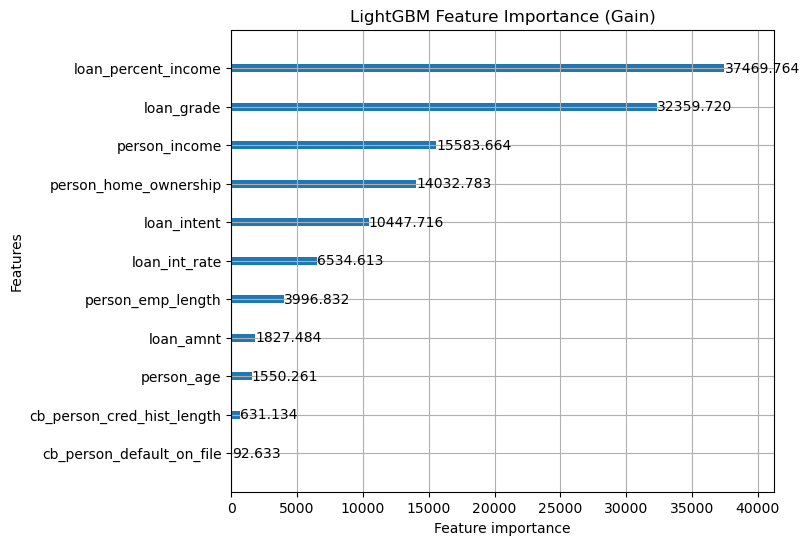

In [15]:
#Plot feature importance using gain as importance type
lgb.plot_importance(lgbm, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Note that we tried RFE and it did not improve the performance of the model. Accuracy and F1 score were both much lower when we use the RFE algorithm with 7,8,9 features vs all features. As a result we will keep all the features in this model, even the ones which are correlated according to the confusion matrix. Now let's find the best combinations of hyperparameters using random search. Those optimized hyperparameters will not significantly improve the performance of the model, but it will definitely improve it. 

In [16]:
# Step 1: Define the parameter space for random search
param_dist = {
    'num_leaves': np.arange(10, 300, 10),  # Number of leaves in the tree
    'learning_rate': np.linspace(0.01, 0.5, 30),  # Learning rate
    'max_depth': np.arange(3, 50, 1),  # Maximum depth of each tree
    'min_child_samples': np.arange(10, 200, 10),  # Minimum number of samples per leaf
    'subsample': np.linspace(0.5, 1.0, 10),  # Fraction of samples used for each tree
    'feature_fraction': np.linspace(0.5, 1.0, 10), # Fraction of features used for each tree
    'reg_alpha': np.logspace(-3, 1, 10),  # L1 regularization
    'reg_lambda': np.logspace(-3, 1, 10),  # L2 regularization
    'verbose' : np.arange(-10, -1, 1) # Verbose
}

# Step 2: Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings to sample
    scoring='roc_auc',  # Metric for evaluation
    cv=3,  # 3-fold cross-validation
    verbose=0,  # Print out progress
    random_state=42,  # Seed for reproducibility
    n_jobs=-1  # Use all available CPU cores
)

# Step 3: Fit the random search to the training data
random_search.fit(x_train, y_train)

# Step 4: Print the best parameters found by random search
print(f"Best parameters found: {random_search.best_params_}")

# Step 5: Use the best estimator to make predictions on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Step 6: Evaluate the model performance
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print(f"Test F1: {f1_score:.4f}")

Best parameters found: {'verbose': -9, 'subsample': 0.5, 'reg_lambda': 3.593813663804626, 'reg_alpha': 0.021544346900318832, 'num_leaves': 20, 'min_child_samples': 180, 'max_depth': 25, 'learning_rate': 0.16206896551724137, 'feature_fraction': 0.6666666666666666}
Test F1: 0.8143


In [17]:
#Define random search (rs) parameters without number estimators
rs_parameters = random_search.best_params_

In [18]:
#Find optimal number of boosting rounds

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

model = lgb.train(
rs_parameters,
train_data,
num_boost_round=20000,
valid_sets=[train_data, test_data],
callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),  lgb.log_evaluation(100)]
)

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0394943	valid_1's l2: 0.0414572
[200]	training's l2: 0.037317	valid_1's l2: 0.0410415
Early stopping, best iteration is:
[190]	training's l2: 0.0374693	valid_1's l2: 0.0410126


In [19]:
#Define random search (rs) parameters with number estimators
rs_parameters['n_estimators'] = model.num_trees()

In [20]:
#Model with default parameters
lgbm = LGBMClassifier(**rs_parameters).fit(x_train, y_train)

In [21]:
#Evaluate on train dataset
print('train')
y_pred = lgbm.predict(x_train) #predict_proba returns an array with 2 elements
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred)
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
print ("Precision : ", precision_score(y_train, y_pred))
print ("Recall : ", recall_score(y_train, y_pred))
print ("Accuracy : ", accuracy_score(y_train, y_pred))
print ("F1-Score : ", f1_score(y_train, y_pred))
print("AUC-ROC score : ", roc_auc_score(y_train, y_pred))
print(cm)

train
Precision :  0.9391949152542373
Recall :  0.7536552193131588
Accuracy :  0.9577111398017101
F1-Score :  0.8362573099415205
AUC-ROC score :  0.8727473116668727
[[34882   287]
 [ 1449  4433]]


In [22]:
#Evaluate on test dataset
print('test')
y_pred = lgbm.predict(x_test) 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
print ("Precision : ", precision_score(y_test, y_pred))
print ("Recall : ", recall_score(y_test, y_pred))
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print ("F1-Score : ", f1_score(y_test, y_pred))
print("AUC-ROC score : ", roc_auc_score(y_test, y_pred))
print(cm)

test
Precision :  0.9084577114427861
Recall :  0.7398703403565641
Accuracy :  0.9530521768784813
F1-Score :  0.8155426529700759
AUC-ROC score :  0.8638529276819181
[[14942   184]
 [  642  1826]]


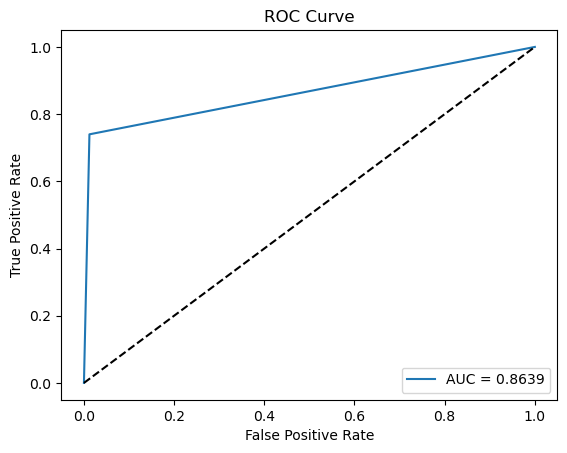

In [23]:
#Calculate ROC curve for test dataset
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

#Plot ROC curve for test dataset
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The optimization of hyperparameters improved auc from 85.96 to 86.39 aka a relative increase of 0.5%. As mentioned previously, the optimization did not signficantly improved performance, but made it slightly better. In order to significantly improve performance, we need to increase either the quantity or the quality of the data : remove correlated features, add new features, delete outliers and fill null values.

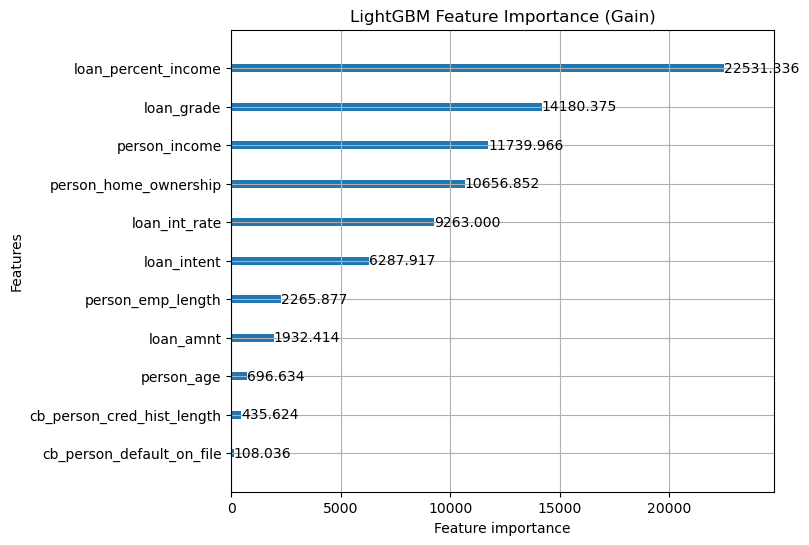

In [24]:
#Plot feature importance using gain as importance type
lgb.plot_importance(lgbm, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [25]:
#Define submission dataframe
df_submission["person_home_ownership"] = df_train["person_home_ownership"].astype("category").cat.codes
df_submission["loan_intent"] = df_train["loan_intent"].astype("category").cat.codes
df_submission["loan_grade"] = df_train["loan_grade"].astype("category").cat.codes
df_submission["cb_person_default_on_file"] = df_train["cb_person_default_on_file"].astype("category").cat.codes
x_submission = df_submission[FEATURES_TRAIN]

In [26]:
#Use model to make predictions on test data
preds = []
preds.append(lgbm.predict_proba(x_submission)[:, 1])

In [27]:
#Save prediction in a submission file
submission = df_submission[['id']]
submission['loan_status'] = np.mean(preds, axis=0)
submission.to_csv('loan_approval_submission.csv', index=False)
print("file saved")

file saved


/var/folders/sw/5v7lnbt97qn024bq0txyyb0h0000gn/T/ipykernel_32624/2860083624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['loan_status'] = np.mean(preds, axis=0)
